In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

import tensorflow as tf
physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], enable=True)

In [2]:
data = pd.read_csv("myo_raw_glove2.csv")

In [3]:
data.head()

,Channel_1,Channel_2,Channel_3,Channel_4,Channel_5,Channel_6,Channel_7,Channel_8,Thumb,Index,Middle,Ring,Pinky
0,22,30,116,106,50,47,38,24,511,511,511,511,511
1,21,39,110,150,53,44,36,26,511,511,511,511,511
2,28,49,139,151,56,44,35,28,511,511,511,511,511
3,31,51,146,154,65,48,33,30,511,511,511,511,511
4,45,60,181,142,76,59,33,29,511,511,511,511,511


In [4]:
finger_names = ['Thumb', 'Index', 'Middle', 'Ring', 'Pinky']
myo_cols = ["Channel_1", "Channel_2", "Channel_3", "Channel_4", "Channel_5", "Channel_6", "Channel_7", "Channel_8"]

In [5]:
df = data.copy(deep=True)

<AxesSubplot:>

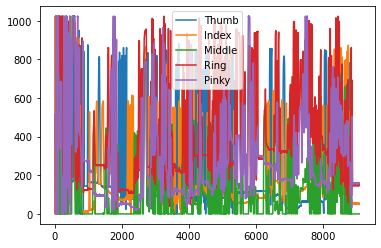

In [6]:
df[finger_names].plot()

<AxesSubplot:>

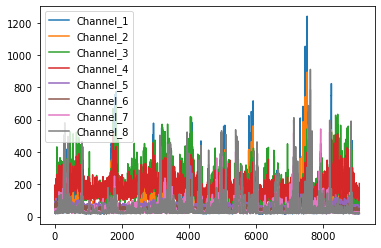

In [7]:
df[myo_cols].plot()

In [8]:
print("Correlation Matrix")
print()

def get_redundant_pairs(df):
    '''Get diagonal and lower triangular pairs of correlation matrix'''
    pairs_to_drop = set()
    cols = df.columns
    for i in range(0, df.shape[1]):
        for j in range(0, i+1):
            pairs_to_drop.add((cols[i], cols[j]))
    return pairs_to_drop

def get_top_abs_correlations(df, n=5):
    au_corr = df.corr().abs().unstack()
    labels_to_drop = get_redundant_pairs(df)
    au_corr = au_corr.drop(labels=labels_to_drop).sort_values(ascending=False)
    return au_corr[0:n]

print("Top Absolute Correlations")
print(get_top_abs_correlations(df, 10))

Correlation Matrix

Top Absolute Correlations
Channel_7  Channel_8    0.955025
Channel_1  Channel_2    0.923527
Channel_5  Channel_6    0.711206
Channel_3  Channel_4    0.694407
Index      Middle       0.599518
Ring       Pinky        0.590854
Channel_6  Channel_7    0.581009
Channel_1  Pinky        0.580883
Channel_2  Channel_3    0.556354
           Pinky        0.547149
dtype: float64


# Making a full hand baseline

In [9]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

x_cols = ['Channel_1', 'Channel_2', 'Channel_3', 'Channel_4', 'Channel_5',
       'Channel_6', 'Channel_7', 'Channel_8']

X = df[x_cols]
y = df.drop(x_cols,1)

train_X, test_X, train_y, test_y = train_test_split(X.to_numpy(), y.to_numpy(), test_size=0.25)

# Making our benchmark model
# Just predict the mean average number of bikes. 
y_train_mean = train_y.mean()

train_preds = np.ones(train_y.shape) * y_train_mean
preds = np.ones(test_y.shape) * y_train_mean

rmse = np.sqrt(mean_squared_error(train_y, train_preds))
print("Train RMSE: %f" % (rmse))

mae = mean_absolute_error(train_y, train_preds)
print("Train MAE: %f" % (mae))

rmse = np.sqrt(mean_squared_error(test_y, preds))
print("Test RMSE: %f" % (rmse))

mae = mean_absolute_error(test_y, preds)
print("Test MAE: %f" % (mae))

r2_score(test_y, preds)

Train RMSE: 256.914784
Train MAE: 201.585006
Test RMSE: 258.040138
Test MAE: 203.039715


-0.16485341099814815

In [10]:
X

,Channel_1,Channel_2,Channel_3,Channel_4,Channel_5,Channel_6,Channel_7,Channel_8
0,22,30,116,106,50,47,38,24
1,21,39,110,150,53,44,36,26
2,28,49,139,151,56,44,35,28
3,31,51,146,154,65,48,33,30
4,45,60,181,142,76,59,33,29
...,...,...,...,...,...,...,...,...
9091,23,22,81,145,62,50,25,23
9092,21,22,95,158,58,45,25,21
9093,20,26,99,163,57,43,23,19
9094,20,25,99,195,54,38,21,20


In [11]:
y

,Thumb,Index,Middle,Ring,Pinky
0,511,511,511,511,511
1,511,511,511,511,511
2,511,511,511,511,511
3,511,511,511,511,511
4,511,511,511,511,511
...,...,...,...,...,...
9091,54,55,0,150,160
9092,52,53,0,147,160
9093,52,53,0,147,160
9094,50,53,0,147,160


# Making a baseline Neural Network

In [12]:
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten

from sklearn.preprocessing import MinMaxScaler, StandardScaler

from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

In [13]:
finger_names = ['Thumb', 'Index', 'Middle', 'Ring', 'Pinky']
myo_cols = ["Channel_1", "Channel_2", "Channel_3", "Channel_4", "Channel_5", "Channel_6", "Channel_7", "Channel_8"]
x_cols = myo_cols
y_cols = finger_names

df = pd.read_csv("myo_raw_glove2.csv")

# Rectification
X = abs(df[x_cols]).values
y = df.drop(x_cols,1).values

# Scaling
rel_hand_scaler = StandardScaler()
emg_scaler = StandardScaler()

ny = rel_hand_scaler.fit_transform(y)
nX = emg_scaler.fit_transform(X)

train_X, test_X, train_y, test_y = train_test_split(nX, ny, test_size=0.25)

In [14]:
model = Sequential()

# The Input Layer :
model.add(Dense(16,input_dim = train_X.shape[1], activation='relu'))

# The Hidden Layers :
model.add(Dense(32,activation='relu'))
model.add(Dense(64,activation='relu'))

# The Output Layer :
model.add(Dense(5,activation='relu'))

# Compile the network :
model.compile(loss='mse', optimizer='Adam')
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 16)                144       
_________________________________________________________________
dense_1 (Dense)              (None, 32)                544       
_________________________________________________________________
dense_2 (Dense)              (None, 64)                2112      
_________________________________________________________________
dense_3 (Dense)              (None, 5)                 325       
Total params: 3,125
Trainable params: 3,125
Non-trainable params: 0
_________________________________________________________________


In [15]:
history = model.fit(train_X, train_y, epochs=200, batch_size=32, validation_data=(test_X, test_y))

Epoch 1/200
214/214 [==============================] - 12s 4ms/step - loss: 0.9623 - val_loss: 0.9032
Epoch 2/200
214/214 [==============================] - 1s 3ms/step - loss: 0.8576 - val_loss: 0.8466
Epoch 3/200
214/214 [==============================] - 1s 3ms/step - loss: 0.8406 - val_loss: 0.8413
Epoch 4/200
214/214 [==============================] - 1s 3ms/step - loss: 0.8426 - val_loss: 0.8359
Epoch 5/200
214/214 [==============================] - 1s 3ms/step - loss: 0.8413 - val_loss: 0.8329
Epoch 6/200
214/214 [==============================] - 1s 3ms/step - loss: 0.8227 - val_loss: 0.8334
Epoch 7/200
214/214 [==============================] - 1s 3ms/step - loss: 0.8388 - val_loss: 0.8305
Epoch 8/200
214/214 [==============================] - 1s 3ms/step - loss: 0.8286 - val_loss: 0.8316
Epoch 9/200
214/214 [==============================] - 1s 3ms/step - loss: 0.8410 - val_loss: 0.8279
Epoch 10/200
214/214 [==============================] - 1s 3ms/step - loss: 0.8269 - val_l

214/214 [==============================] - 1s 3ms/step - loss: 0.7020 - val_loss: 0.7252
Epoch 82/200
214/214 [==============================] - 1s 3ms/step - loss: 0.6628 - val_loss: 0.6791
Epoch 83/200
214/214 [==============================] - 1s 3ms/step - loss: 0.6256 - val_loss: 0.6719
Epoch 84/200
214/214 [==============================] - 1s 3ms/step - loss: 0.6341 - val_loss: 0.6759
Epoch 85/200
214/214 [==============================] - 1s 3ms/step - loss: 0.6234 - val_loss: 0.6733
Epoch 86/200
214/214 [==============================] - 1s 3ms/step - loss: 0.6257 - val_loss: 0.6799
Epoch 87/200
214/214 [==============================] - 1s 3ms/step - loss: 0.6183 - val_loss: 0.6880
Epoch 88/200
214/214 [==============================] - 1s 3ms/step - loss: 0.6391 - val_loss: 0.6801
Epoch 89/200
214/214 [==============================] - 1s 3ms/step - loss: 0.6087 - val_loss: 0.6805
Epoch 90/200
214/214 [==============================] - 1s 3ms/step - loss: 0.6094 - val_loss: 

Epoch 161/200
214/214 [==============================] - 1s 3ms/step - loss: 0.5890 - val_loss: 0.7040
Epoch 162/200
214/214 [==============================] - 1s 3ms/step - loss: 0.5613 - val_loss: 0.6880
Epoch 163/200
214/214 [==============================] - 1s 3ms/step - loss: 0.5561 - val_loss: 0.6920
Epoch 164/200
214/214 [==============================] - 1s 3ms/step - loss: 0.5604 - val_loss: 0.7018
Epoch 165/200
214/214 [==============================] - 1s 3ms/step - loss: 0.5662 - val_loss: 0.6912
Epoch 166/200
214/214 [==============================] - 1s 3ms/step - loss: 0.5736 - val_loss: 0.6896
Epoch 167/200
214/214 [==============================] - 1s 3ms/step - loss: 0.5584 - val_loss: 0.6831
Epoch 168/200
214/214 [==============================] - 1s 3ms/step - loss: 0.5667 - val_loss: 0.6883
Epoch 169/200
214/214 [==============================] - 1s 3ms/step - loss: 0.5669 - val_loss: 0.6869
Epoch 170/200
214/214 [==============================] - 1s 3ms/step - lo

In [16]:
# Evaluate the model on the test data
mse = model.evaluate(test_X, test_y)
mse

72/72 [==============================] - 0s 1ms/step - loss: 0.6918


0.6918104887008667

In [17]:
# Training Set
train_preds = model.predict(train_X) # scaled inputs here

# Scaling back the prediction
train_preds = rel_hand_scaler.inverse_transform(train_preds)
# Scaling back the goals
train_goal = rel_hand_scaler.inverse_transform(train_y)

MSE = mean_squared_error(train_goal, train_preds)  # first 2 steps, combined
print("Train MSE: ", MSE)
print("Train RMSE: ", np.sqrt(MSE))  # 3rd step
MAE = mean_absolute_error(train_goal, train_preds)
print("Train MAE: ", MAE)

print()
# Test Set
test_preds = model.predict(test_X) # scaled inputs here

# Scaling back the prediction
test_preds = rel_hand_scaler.inverse_transform(test_preds)
# Scaling back the goals
test_goal = rel_hand_scaler.inverse_transform(test_y)

MSE = mean_squared_error(test_goal, test_preds)  # first 2 steps, combined
print("Test MSE: ", MSE)
print("Test RMSE: ", np.sqrt(MSE))  # 3rd step
MAE = mean_absolute_error(test_goal, test_preds)
print("Test MAE: ", MAE)

Train MSE:  30890.951319959695
Train RMSE:  175.75821835680884
Train MAE:  142.92578456166274

Test MSE:  38579.93181750374
Test RMSE:  196.41774822429807
Test MAE:  154.84087927423238


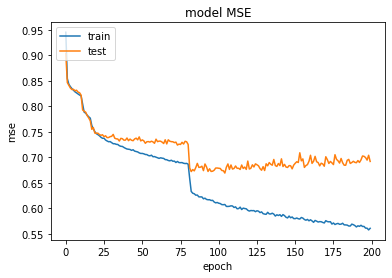

In [18]:
# summarize history for loss
%matplotlib inline
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model MSE')
plt.ylabel('mse')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# Plot the predicted vs ground truth

In [19]:
y_cols_pred = []
for i in y_cols:
    y_cols_pred.append(i+"_pred")
    
preds = pd.DataFrame(train_preds, columns=y_cols_pred)
goal = pd.DataFrame(train_goal, columns=y_cols)
vis = pd.concat([preds, goal], axis=1)

In [20]:
vis

,Thumb_pred,Index_pred,Middle_pred,Ring_pred,Pinky_pred,Thumb,Index,Middle,Ring,Pinky
0,203.941727,197.805405,154.055298,640.830627,299.428772,112.0,57.0,243.0,891.0,508.0
1,203.941727,197.805405,154.055298,856.470215,299.428772,142.0,115.0,75.0,852.0,332.0
2,203.941727,427.922913,333.039093,748.467529,722.716858,281.0,894.0,936.0,974.0,813.0
3,203.941727,197.805405,154.055298,430.992950,299.428772,271.0,71.0,0.0,297.0,278.0
4,577.472351,669.199890,501.611206,800.515137,658.390625,679.0,779.0,611.0,926.0,772.0
...,...,...,...,...,...,...,...,...,...,...
6817,203.941727,197.805405,383.404846,430.992950,299.428772,83.0,71.0,432.0,370.0,99.0
6818,203.941727,197.805405,154.055298,430.992950,299.428772,153.0,644.0,254.0,208.0,116.0
6819,203.941727,197.805405,154.055298,430.992950,299.428772,656.0,124.0,111.0,304.0,168.0
6820,203.941727,197.805405,154.055298,430.992950,299.428772,67.0,137.0,111.0,304.0,164.0


<AxesSubplot:>

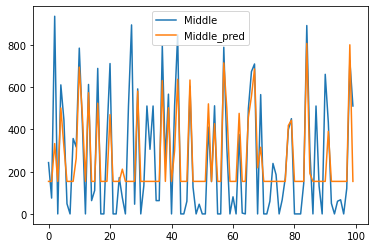

In [22]:
finger = "Middle"
vis[[finger,finger+'_pred']].iloc[0:100].plot()

### Save the model and the scalers

In [23]:
import joblib

model_name = "NNBasic"

model.save(f"../models/{model_name}.h5")
# Save hand scaler to file.
# Scales the output of the network, the relative position of the hand, min_max
joblib.dump(rel_hand_scaler, f'../models/{model_name}-Hand.gz')

# Scales the input to the network, the emg data. 
joblib.dump(emg_scaler, f'../models/{model_name}-EMG.gz')

['../models/NNBasic-EMG.gz']

In [24]:
# Making a prediction in the prediction script.
from keras.models import load_model
model = load_model(f"../models/{model_name}.h5")

input_scaler = joblib.load(f'../models/{model_name}-EMG.gz')
output_scaler = joblib.load(f'../models/{model_name}-Hand.gz')

# Get some input data
semg_input = np.array([[ 31, 140, 140,  83,  42,  30,  22,  21]])
# Scale the input
scaled_input = input_scaler.transform(semg_input)
# Get a prediction
pred = model.predict(scaled_input)
# Scale it back to a value
scaled_pred = output_scaler.inverse_transform(pred)
scaled_pred

array([[203.94173, 197.8054 , 154.0553 , 430.99295, 299.42877]],
      dtype=float32)

In [25]:
prediction = model.predict(test_X) # scaled inputs here
print(prediction)

# Scaling back the prediction
preds = rel_hand_scaler.inverse_transform(prediction)
# Scaling back the goals
goal = rel_hand_scaler.inverse_transform(test_y)

MSE = mean_squared_error(goal, preds)  # first 2 steps, combined
print("MSE: ", MSE)
print("RMSE: ", np.sqrt(MSE))  # 3rd step
MAE = mean_absolute_error(goal, preds)
print("MAE: ", MAE)

[[0.         0.         0.         0.         0.        ]
 [0.         0.03264558 0.26243007 0.         0.        ]
 [0.54437625 0.         0.         0.         0.        ]
 ...
 [0.         0.         0.         0.         0.        ]
 [2.1910014  2.3081264  1.4408488  1.0059843  0.9177617 ]
 [0.84547764 0.         0.         0.         0.        ]]
MSE:  38579.93181750374
RMSE:  196.41774822429807
MAE:  154.84087927423238
